In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import cv2

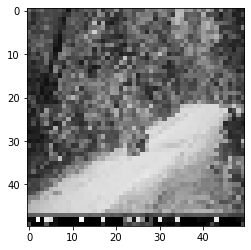

In [2]:
data = np.load("../Data/Data_Myanmar/training_data_myanmar.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [3]:
# Normalize pixel values to be between 0 and 1
for pictures in data:
  pictures[0] = pictures[0] / 255

class_names = ["cow", "cow_cart", "elephant_canopy_level", "elephant_ground_level", "poachers", "truck", "villagers", "three_weel_cart"]

In [4]:
# get the labels
def get_labels(data):
  images, labels = [], []
  for items in data:
    images.append(items[0])
    labels.append([np.where(items[1] == 1)])
  images = np.array(images)
  labels = np.array(labels)

  return images, labels

train_data = data[:2600]
test_data = data[2600:]

train_images, train_labels = get_labels(train_data)
test_images, test_labels = get_labels(test_data)

# expand dimmentions for greyscale
train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)
train_labels = tf.expand_dims(train_labels, axis=-1)
test_labels = tf.expand_dims(test_labels, axis=-1)

# labels = tf.expand_dims(labels, axis=-1)
# images = tf.expand_dims(images, axis=-1)


In [5]:
# creating th model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_images.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8))

model.summary()  # summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [6]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# import datetime, os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

# With tensorboard
# history = model.fit(images, labels, epochs=4, 
#                     validation_split=0.2, callbacks=[tensorboard])

Epoch 1/4
82/82 [==============================] - 4s 48ms/step - loss: 0.8023 - accuracy: 0.8315 - val_loss: 0.5352 - val_accuracy: 0.8509
Epoch 2/4
82/82 [==============================] - 3s 39ms/step - loss: 0.4497 - accuracy: 0.8551 - val_loss: 0.3962 - val_accuracy: 0.7946
Epoch 3/4
82/82 [==============================] - 3s 35ms/step - loss: 0.4244 - accuracy: 0.8061 - val_loss: 0.3490 - val_accuracy: 0.8158
Epoch 4/4
82/82 [==============================] - 3s 36ms/step - loss: 0.2794 - accuracy: 0.8209 - val_loss: 0.2612 - val_accuracy: 0.7759


In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

11/11 - 0s - loss: 0.2612 - accuracy: 0.7759
0.7759122848510742


In [8]:
predictions = model.predict_on_batch(test_images)
predictions[5]

array([-1.6800535 , -2.6296282 ,  0.17966728,  3.698901  ,  0.8536564 ,
        2.8628402 ,  6.121823  , -2.1294541 ], dtype=float32)

In [9]:
# # launch tensorboard
# %tensorboard --logdir logs
test = tf.reshape(test_labels, [328])
# test_labels.shape

In [10]:
# score per class
Y_test = tf.reshape(test_labels, [328])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(test_images)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           2       1.00      0.38      0.55         8
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.89      0.92      0.91        26
           6       0.94      0.99      0.96       280

    accuracy                           0.93       328
   macro avg       0.55      0.44      0.47       328
weighted avg       0.90      0.93      0.91       328



C:\Users\Siebren\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\Siebren\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
